In [165]:
# Deep Neural Networks:
import tensorflow as tf; print('We\'re using TF-{}.'.format(tf.__version__))
# import keras; print('We\'re using Keras-{}.'.format(keras.__version__))
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                                     Conv1D, Conv2D, MaxPooling1D, MaxPooling2D,
                                     LSTM, GRU, Embedding, Bidirectional, Concatenate)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import matplotlib.patches as patches

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, matthews_corrcoef, precision_score, roc_curve, auc)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)

#Utilities:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical as labelEncoding
from keras.utils import plot_model  
 

We're using TF-2.14.0.


In [166]:
def Network(input_shapes):
    inputs = []
    heads = []

    # Create input layers for each head
    for input_shape in input_shapes:
        # input_layer = Input(shape=input_shape)
        # inputs.append(input_layer)

        # x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(input_layer)
        # x = BatchNormalization()(x)
        # x = Dropout(rate=0.70)(x)

        # x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(l=0.01))(x)
        # x = BatchNormalization()(x)
        # x = Dropout(rate=0.50)(x)

        # head = Flatten()(x)
        # heads.append(head)
        input_layer = Input(shape=input_shape)
        inputs.append(input_layer)

        x = Conv1D(filters=16, kernel_size=3, activation='relu')(input_layer)
        x = MaxPooling1D(2)(x)
        x = Conv1D(filters=8, kernel_size=3, activation='relu')(x)
        x = MaxPooling1D(2)(x)
        head = Flatten()(x)
        heads.append(head)

    # Concatenate all heads
    merge = Concatenate()(heads)

    output = Dense(units=3, activation='softmax')(merge)

    # output = Dense(units=16, activation='relu')(merge)
    # output = BatchNormalization()(output)
    # output = Dropout(rate=0.60)(output)

    # output = Dense(units=8, activation='relu')(output)
    # output = BatchNormalization()(output)
    # output = Dropout(rate=0.50)(output)

    # output = Dense(units=3, activation='softmax')(output)

    return Model(inputs=inputs, outputs=output)

# 
# input_shapes = [(100, 1), (200, 1), (300, 1), (769,1),(682,1)]  # Add 17 more shapes as needed
# model = Network(input_shapes=input_shapes)

In [196]:
#加载数据和标签，划分训练集和测试集后再按染色体划分成要输入的模型的数据
#每条染色体有独立的特征提取器
#多个输入以适应染色体的不同大小
import h5py
# import re
import pickle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

group_id = 'compartment_raw'
df = '/home/notebook/scCompartment_cortex250k.hdf5'
file = h5py.File(df, 'r')
bin_chr = np.array([chrom.decode('utf-8') for chrom in file['compartment_raw']['bin']['chrom']])

cell_keys = list(filter(lambda key: 'cell_' in key, file[group_id].keys()))
cell_list_len=len(cell_keys)

datasets = [file[group_id][f'cell_{i}'][()] for i in range(cell_list_len)]
data = pd.DataFrame({f'cell_{i}': dataset for i, dataset in enumerate(datasets)})
# chr_list = list(np.unique(bin_chr))
# chr_list.sort(key=lambda l: int(re.findall('\d+', l)[0]))
chr_list = ["chr1","chr2","chr3","chr4","chr5",
    "chr6","chr7","chr8","chr9","chr10",
    "chr11","chr12","chr13","chr14","chr15",
    "chr16","chr17","chr18","chr19"]
# chr_list = ["chr1","chr2"]
chr_index ={}
# chr_data =[]
print(chr_list)
for i in range(len(chr_list)):
    chr_index[i] = np.where(bin_chr == chr_list[i])[0]
    # temp_data =data.iloc[chr_index[i], :]
    # chr_data.append(temp_data)


label_path = '/home/notebook/label_info.pickle'
y=pickle.load(open(label_path, "rb"))
print(f"Label file to load: {label_path}")
label=pd.DataFrame()
label['cell_id']= data.columns
label['cell_type']=y['cell_type']


data_np=np.array(data.T)
label_encoder = LabelEncoder()
indexed_labels = label_encoder.fit_transform(label['cell_type'].values)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(indexed_labels.reshape(-1, 1))
encoded_labels_df = pd.DataFrame(encoded_labels, columns=[f'_{i}' for i in range(encoded_labels.shape[1])])
X_train, X_test, y_train, y_test = train_test_split(data_np, encoded_labels_df, test_size=0.2, random_state=123)
X_train_3d = np.expand_dims(X_train, axis=2)
X_test_3d = np.expand_dims(X_test, axis=2)

train_dataset =[]
test_dataset = []
input_shapes_list =[]
for i in range(len(chr_list)):
# for i in range(2):
    train_dataset.append(X_train_3d[:,chr_index[i],:])
    input_shapes_list.append(X_train_3d[:,chr_index[i],:].shape[1:])
    test_dataset.append(X_test_3d[:,chr_index[i],:])
    # train_dataset.append(X_train_3d[:,chr_index[0],:])
    # input_shapes_list.append(X_train_3d[:,chr_index[0],:].shape[1:])
    # test_dataset.append(X_test_3d[:,chr_index[0],:])
dataset = (train_dataset,y_train,test_dataset,y_test) 

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']
Label file to load: /home/notebook/label_info.pickle


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_82 (InputLayer)       [(None, 770, 1)]             0         []                            
                                                                                                  
 input_83 (InputLayer)       [(None, 713, 1)]             0         []                            
                                                                                                  
 input_84 (InputLayer)       [(None, 628, 1)]             0         []                            
                                                                                                  
 input_85 (InputLayer)       [(None, 612, 1)]             0         []                            
                                                                                           

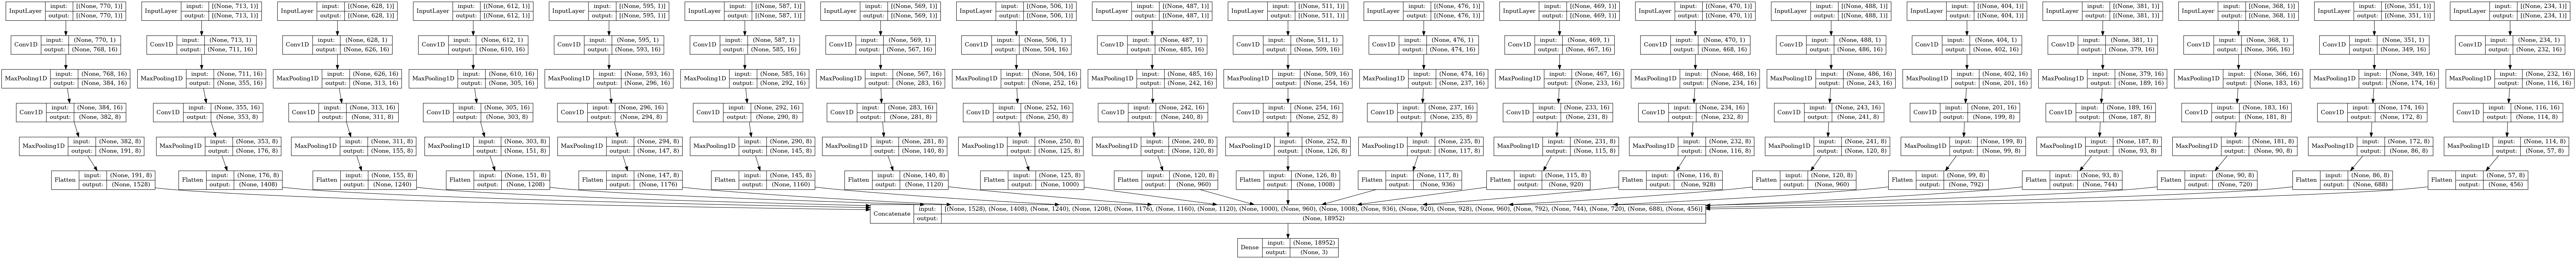

In [198]:
model = Network(input_shapes=input_shapes_list)
model.summary()
plot_model(model, to_file='model-chr1-chr2.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [199]:
def train(model,dataset,epochs,batch_size,lr):
    Optimizer=Adam(learning_rate=lr)
    X_train_3d, y_train, X_test_3d ,y_test=dataset
    model.compile(loss='categorical_crossentropy', optimizer=Optimizer, 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss',  
                                mode='min',          
                                patience=5,          
                                verbose=1)

    # model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
    # _, accuracy = model.evaluate(X_test_3d, y_test)
    model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test))
    _, accuracy = model.evaluate(X_test_3d, y_test)
    print('Accuracy: %.2f%%' % (accuracy * 100))
    # model.save("test_model.h5")

    return model

epochs =3
batch_size = 16
lr = 0.001

train(model,dataset,epochs,batch_size,lr)

Epoch 1/3
54/54 [==============================] - 12s 54ms/step - loss: 0.9952 - accuracy: 0.5663 - val_loss: 0.8484 - val_accuracy: 0.5907
Epoch 2/3
54/54 [==============================] - 2s 33ms/step - loss: 0.5875 - accuracy: 0.7767 - val_loss: 0.5932 - val_accuracy: 0.7721
Epoch 3/3
7/7 [==============================] - 0s 14ms/step - loss: 0.5478 - accuracy: 0.7953
Accuracy: 79.53%


In [207]:
background = [array[np.random.choice(array.shape[0], 100, replace=False)] for array in train_dataset]



In [214]:
import shap
explainer = shap.GradientExplainer(model, background)


In [213]:
test_dataset[1].shape[0]
# np.shape(test_dataset)[0]

215

In [216]:
from tqdm import tqdm
out_list = []
num_samples = test_dataset[1].shape[0]
# num_samples = np.shape(ex_data)[0]
# print("num_samples:",num_samples)
for sample in tqdm(range(num_samples)):
    # shap
    shap_values = explainer.shap_values([array[sample : sample + 1] for array in test_dataset])
    out_list.append(shap_values)
# shap_arr = np.squeeze(np.array(out_list))
#对于多输入模型 的 shap值 np.squeeze可能不再适用

100%|██████████| 215/215 [03:57<00:00,  1.11s/it]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (215, 3, 19, 1) + inhomogeneous part.

In [259]:
#需要将不同染色体拼接到一起
# 拼接第三级元素
concatenated_third_level = [[np.concatenate(array_list, axis=1) for array_list in sublist] for sublist in out_list]


In [260]:
# concatenated_third_level
shap_arr = np.squeeze(np.array(concatenated_third_level))

In [261]:
#将所有染色体的SHAP值拼接到了一起，可以像之前一样操作
shap_arr.shape

(215, 3, 9619)

In [247]:
len(out_list)
215

215

In [248]:
import numpy as np

def recursive_squeeze(data):
    if isinstance(data, list):
        return [recursive_squeeze(item) for item in data]
    else:
        return np.squeeze(data)

# 示例：对整个 out_list 进行 np.squeeze 操作
squeezed_list = recursive_squeeze(out_list)

# 打印结果
print(len(out_list))  # 原始列表长度
print(len(squeezed_list))  # 经过 squeeze 操作后的列表长度


215
215


In [257]:
type(squeezed_list[0][0])

list

In [244]:
squeezed_list = [[np.squeeze(array) for array in sublist2] for sublist1 in out_list for sublist2 in sublist1]
len(squeezed_list)
645

In [246]:
len(squeezed_list)

645

In [240]:
# 使用两层循环展平第三级的列表
flattened_list = [item for sublist1 in out_list for sublist2 in sublist1 for item in sublist2]

In [242]:
len(flattened_list)

12255

In [232]:
a=np.array(out_list[0][0][0])

In [233]:
a.shape

(1, 770, 1)

In [210]:
background[5].shape

(100, 587, 1)

In [206]:
train_dataset[3].shape

(860, 612, 1)

In [ ]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [train_dataset[0][1], train_dataset[1][1]])

In [189]:
import shap

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, [train_dataset[0][1], train_dataset[1][1]])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([test_dataset[0][:2], test_dataset[1][:2]])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [195]:
train_dataset[1].shape

(860, 770, 1)

In [190]:
test_dataset[1][:2].shape

(2, 770, 1)

In [188]:
shap_values[0][1].shape

(1, 770, 1)

In [179]:
test_dataset[1][1].shape

(713, 1)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 100, 1)]             0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 300, 1)]             0         []                            
                                                                                                  
 input_27 (InputLayer)       [(None, 769, 1)]             0         []                            
                                                                                            

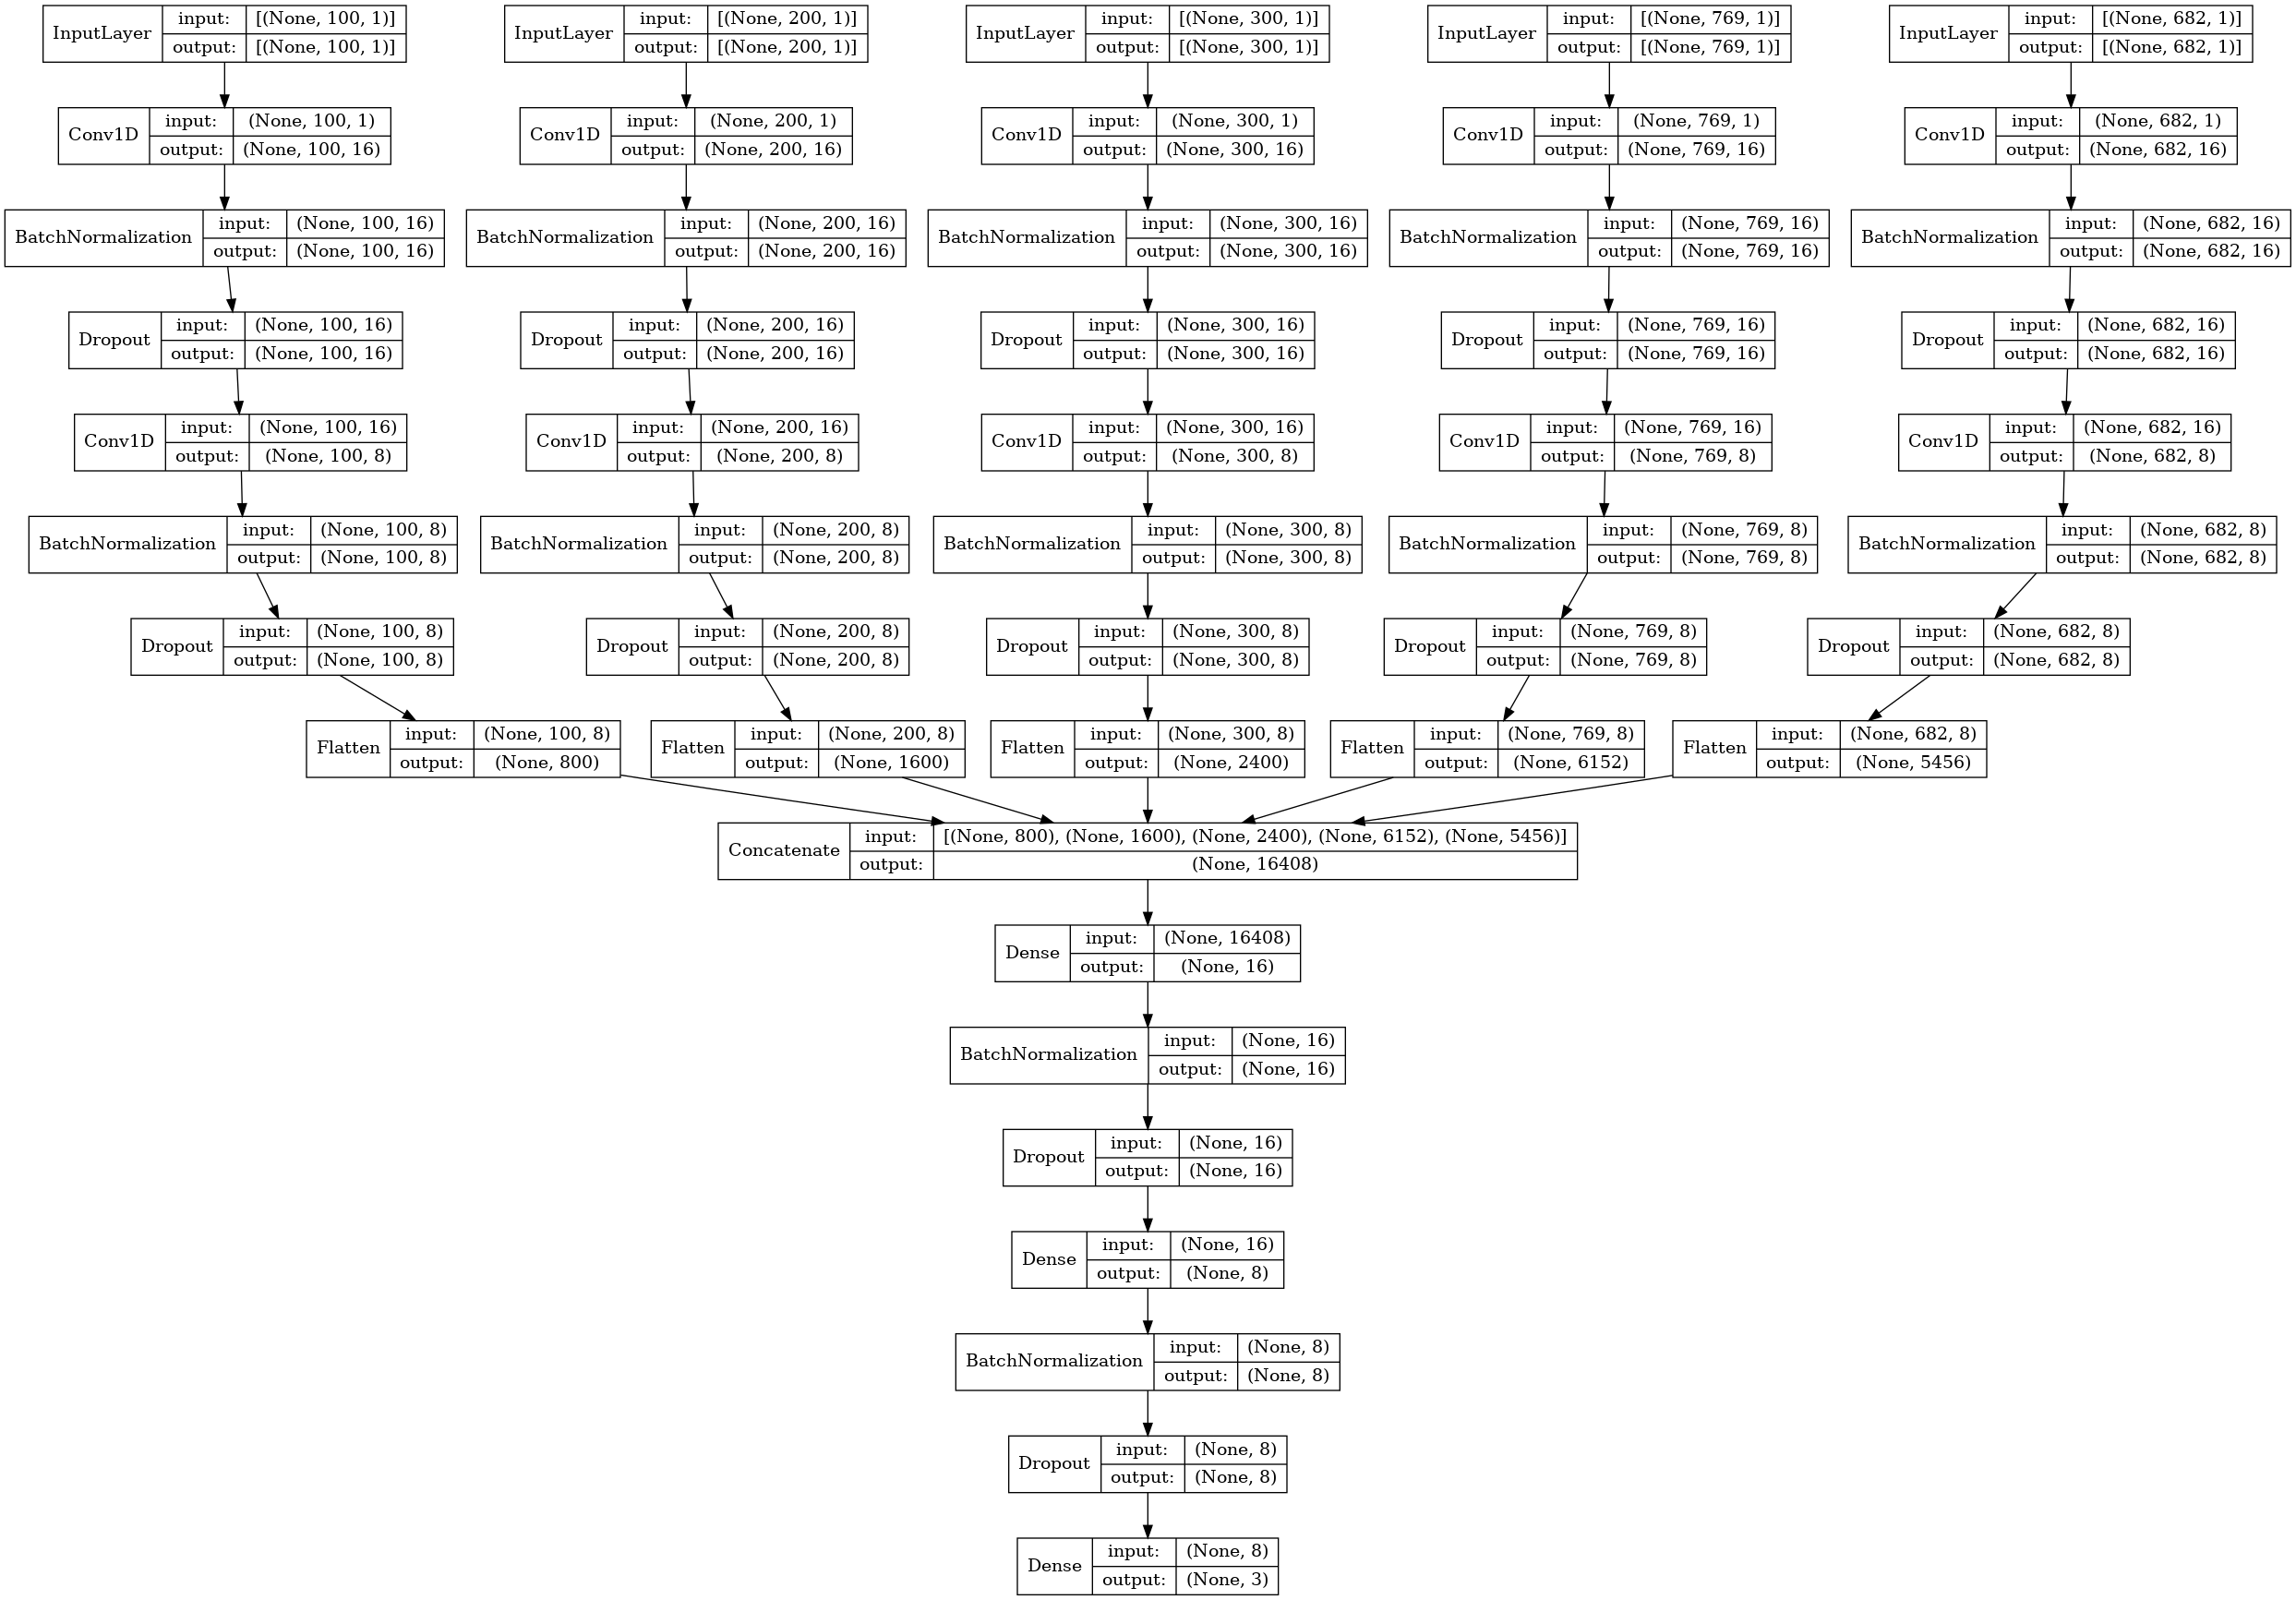

In [7]:
from keras.utils import plot_model  
model = Network(input_shapes=input_shapes)
model.summary()
plot_model(model, to_file='model-500-164.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [25]:
#按染色体加载和划分数据集测试
import h5py
import re


group_id = 'compartment_raw'
df = '/home/notebook/scCompartment_cortex250k.hdf5'
file = h5py.File(df, 'r')
bin_chr = np.array([chrom.decode('utf-8') for chrom in file['compartment_raw']['bin']['chrom']])

cell_keys = list(filter(lambda key: 'cell_' in key, file[group_id].keys()))
cell_list_len=len(cell_keys)

datasets = [file[group_id][f'cell_{i}'][()] for i in range(cell_list_len)]
data = pd.DataFrame({f'cell_{i}': dataset for i, dataset in enumerate(datasets)})
# chr_list = list(np.unique(bin_chr))
# chr_list.sort(key=lambda l: int(re.findall('\d+', l)[0]))
chr_list = ["chr1","chr2","chr3","chr4","chr5",
    "chr6","chr7","chr8","chr9","chr10",
    "chr11","chr12","chr13","chr14","chr15",
    "chr16","chr17","chr18","chr19"]
chr_index ={}
# chr_data =[]
print(chr_list)
for i in range(len(chr_list)):
    chr_index[i] = np.where(bin_chr == chr_list[i])[0]
    # temp_data =data.iloc[chr_index[i], :]
    # chr_data.append(temp_data)



['chr1', 'chr2', 'chr3']


In [29]:
import pickle
label_path = '/home/notebook/label_info.pickle'
y=pickle.load(open(label_path, "rb"))
print(f"Label file to load: {label_path}")
label=pd.DataFrame()
label['cell_id']= data.columns
label['cell_type']=y['cell_type']

Label file to load: /home/notebook/label_info.pickle


In [32]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
data_np=np.array(data.T)
label_encoder = LabelEncoder()
indexed_labels = label_encoder.fit_transform(label['cell_type'].values)
onehot_encoder = OneHotEncoder(sparse=False)
encoded_labels = onehot_encoder.fit_transform(indexed_labels.reshape(-1, 1))
encoded_labels_df = pd.DataFrame(encoded_labels, columns=[f'_{i}' for i in range(encoded_labels.shape[1])])
X_train, X_test, y_train, y_test = train_test_split(data_np, encoded_labels_df, test_size=0.2, random_state=123)
X_train_3d = np.expand_dims(X_train, axis=2)
X_test_3d = np.expand_dims(X_test, axis=2)

/usr/local/anaconda/envs/hic/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
X_train_3d[:,chr_index[2],:].shape[1:]

(628, 1)

In [154]:
chr_list = ["chr1","chr2","chr3","chr4","chr5",
    "chr6","chr7","chr8","chr9","chr10",
    "chr11","chr12","chr13","chr14","chr15",
    "chr16","chr17","chr18","chr19"]
chr_index ={}
# chr_data =[]
print(chr_list)
for i in range(len(chr_list)):
    chr_index[i] = np.where(bin_chr == chr_list[i])[0]

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']


In [158]:
train_dataset =[]
test_dataset = []
input_shapes_list =[]
for i in range(len(chr_list)):
# for i in range(2):
    train_dataset.append(X_train_3d[:,chr_index[i],:])
    input_shapes_list.append(X_train_3d[:,chr_index[i],:].shape[1:])
    test_dataset.append(X_test_3d[:,chr_index[i],:])
    # train_dataset.append(X_train_3d[:,chr_index[0],:])
    # input_shapes_list.append(X_train_3d[:,chr_index[0],:].shape[1:])
    # test_dataset.append(X_test_3d[:,chr_index[0],:])
dataset = (train_dataset,y_train,test_dataset,y_test) 

In [159]:
dataset = (train_dataset,y_train,test_dataset,y_test)

In [160]:
input_shapes_list

[(770, 1),
 (713, 1),
 (628, 1),
 (612, 1),
 (595, 1),
 (587, 1),
 (569, 1),
 (506, 1),
 (487, 1),
 (511, 1),
 (476, 1),
 (469, 1),
 (470, 1),
 (488, 1),
 (404, 1),
 (381, 1),
 (368, 1),
 (351, 1),
 (234, 1)]

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 770, 1)]             0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 713, 1)]             0         []                            
                                                                                                  
 input_42 (InputLayer)       [(None, 628, 1)]             0         []                            
                                                                                                  
 input_43 (InputLayer)       [(None, 612, 1)]             0         []                            
                                                                                           

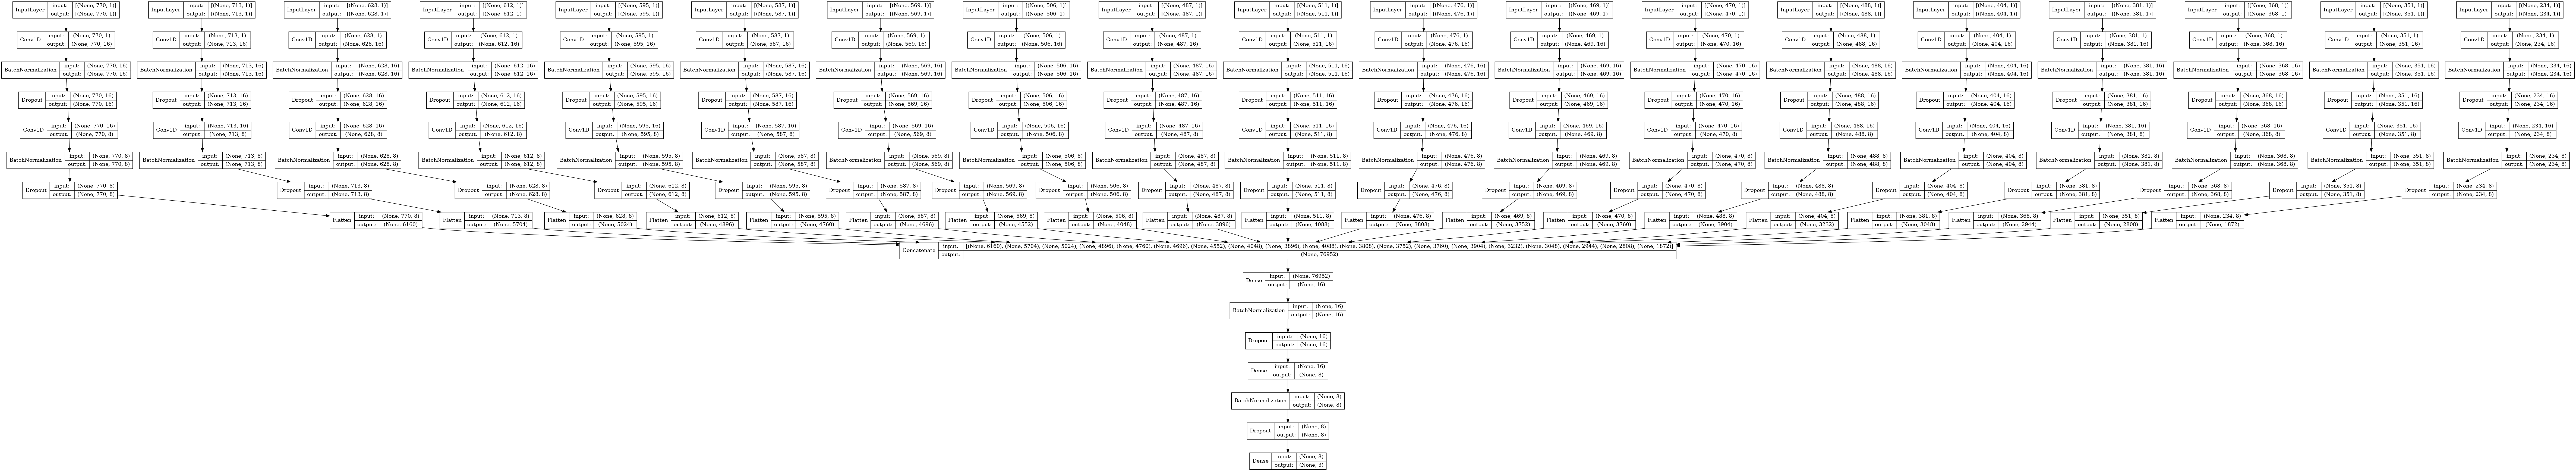

In [161]:
model = Network(input_shapes=input_shapes_list)
model.summary()
plot_model(model, to_file='model-chr1-3.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [164]:
def train(model,dataset,epochs,batch_size,lr):
    Optimizer=Adam(learning_rate=lr)
    X_train_3d, y_train, X_test_3d ,y_test=dataset
    model.compile(loss='categorical_crossentropy', optimizer=Optimizer, 
                    metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss',  
                                mode='min',          
                                patience=5,          
                                verbose=1)

    # model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test), callbacks=[early_stopping])
    # _, accuracy = model.evaluate(X_test_3d, y_test)
    model.fit(X_train_3d, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_3d, y_test))
    _, accuracy = model.evaluate(X_test_3d, y_test)
    print('Accuracy: %.2f%%' % (accuracy * 100))
    # model.save("test_model.h5")

    return model

epochs =300
batch_size = 16
lr = 0.001

train(model,dataset,epochs,batch_size,lr)

Epoch 1/300
54/54 [==============================] - 34s 139ms/step - loss: 0.3972 - accuracy: 0.8360 - val_loss: 0.4754 - val_accuracy: 0.8558
Epoch 2/300
54/54 [==============================] - 5s 96ms/step - loss: 0.4088 - accuracy: 0.8500 - val_loss: 0.5948 - val_accuracy: 0.8326
Epoch 3/300
54/54 [==============================] - 4s 78ms/step - loss: 0.4060 - accuracy: 0.8523 - val_loss: 0.6041 - val_accuracy: 0.8186
Epoch 4/300
54/54 [==============================] - 4s 75ms/step - loss: 0.4193 - accuracy: 0.8256 - val_loss: 0.4789 - val_accuracy: 0.8884
Epoch 5/300
54/54 [==============================] - 4s 75ms/step - loss: 0.4060 - accuracy: 0.8488 - val_loss: 0.5814 - val_accuracy: 0.8233
Epoch 6/300
54/54 [==============================] - 4s 75ms/step - loss: 0.4262 - accuracy: 0.8442 - val_loss: 0.6900 - val_accuracy: 0.8000
Epoch 7/300
54/54 [==============================] - 4s 74ms/step - loss: 0.3765 - accuracy: 0.8558 - val_loss: 0.4671 - val_accuracy: 0.8512
Epoc

In [151]:
# background =[train_dataset[0][0],train_dataset[1][0],train_dataset[2][0]]
# ex_data = [train_dataset[0][1],train_dataset[1][1],train_dataset[2][1]]
background =[train_dataset[0][0],train_dataset[1][0]]
ex_data = [train_dataset[0][1],train_dataset[1][1]]

In [122]:
train_dataset[1][1].shape

(713, 1)

In [76]:
background

[array([[ 3.85512137e-01],
        [ 4.83899467e-01],
        [ 5.90990554e-01],
        [ 6.25433292e-01],
        [ 6.29615776e-01],
        [ 6.47384521e-01],
        [ 9.93961366e-01],
        [ 1.36735173e+00],
        [ 1.12588901e+00],
        [ 4.30082456e-01],
        [ 6.83167817e-02],
        [ 3.49244695e-01],
        [ 1.07035884e+00],
        [ 1.29545107e+00],
        [ 1.15956248e+00],
        [ 7.41039830e-01],
        [ 4.61209571e-01],
        [ 1.25914096e-01],
        [-2.58527321e-01],
        [-8.03606484e-01],
        [-1.17302385e+00],
        [-1.14325819e+00],
        [-4.89980973e-01],
        [ 7.92125370e-02],
        [ 3.91442104e-01],
        [ 2.30235037e-01],
        [ 4.39778642e-01],
        [ 6.21681110e-01],
        [ 2.66851500e-01],
        [-1.75898686e-01],
        [-2.02853331e-01],
        [-7.06765095e-02],
        [-2.22457789e-01],
        [-7.80296936e-01],
        [-1.35635704e+00],
        [-1.73665895e+00],
        [-1.69814302e+00],
 

In [73]:
train_dataset[0:3][2].shape

(860, 628, 1)

In [74]:
ex_data = train_dataset[0:3][1]

TypeError: list indices must be integers or slices, not tuple

In [152]:
import shap
# e = shap.DeepExplainer(model, background)
e = shap.GradientExplainer(model, background)
# print("e.expected_value:",e.expected_value)

In [153]:
shap_values = e.shap_values(ex_data)

ValueError: cannot reshape array of size 50 into shape (770,1)

In [30]:
label

,cell_id,cell_type
0,cell_0,CX1
1,cell_1,CX1
2,cell_2,CX1
3,cell_3,CX1
4,cell_4,CX1
...,...,...
1070,cell_1070,CX3
1071,cell_1071,CX3
1072,cell_1072,CX3
1073,cell_1073,CX3


In [28]:
chr_data[2]

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,...,cell_1065,cell_1066,cell_1067,cell_1068,cell_1069,cell_1070,cell_1071,cell_1072,cell_1073,cell_1074
1483,-0.050647,0.773225,-0.554041,-0.046526,-0.193662,-0.987430,-0.062250,0.105709,0.502688,-0.194721,...,-0.057339,-0.293406,0.811117,-0.274405,-0.596559,-0.492427,0.769382,-0.214928,-0.431151,0.064381
1484,-0.086909,0.218861,-0.408394,0.096862,-0.453089,-0.951213,-0.334264,0.030510,0.450278,-0.164329,...,-0.218089,-0.300578,0.183324,-0.274595,-0.643998,-0.506905,0.101909,-0.342453,-0.499066,0.063896
1485,0.258315,0.042086,-0.204835,0.554717,-0.573367,-0.880714,-0.550516,0.046253,0.393766,-0.174959,...,-0.633903,0.106544,-0.512695,-0.211131,-0.847866,-0.614179,-0.035440,-0.277074,-0.586191,0.149871
1486,0.609064,-0.097917,0.295074,0.894012,-0.599532,-0.646060,-0.615657,0.034064,0.298994,-0.194593,...,-0.763607,0.259946,-0.810461,-0.147621,-1.045602,-0.582245,-0.061113,-0.190230,-0.694788,0.181231
1487,0.767785,-0.137043,0.361756,1.064826,-0.595830,-0.201277,-0.535132,0.130178,0.226649,-0.164956,...,-0.673051,-0.032389,-0.746656,-0.287569,-0.942577,-0.380123,-0.123143,-0.187837,-0.744768,0.167677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.613547,0.672197,0.277400,0.328131,0.777219,0.670792,0.164567,1.166714,0.531601,0.705732,...,-0.197982,-2.189855,-0.152356,0.621583,0.942068,1.046024,0.780631,0.765930,-0.708036,0.788409
2107,0.624974,0.942375,0.306952,0.244637,0.770928,0.654482,0.204163,1.147739,0.584551,0.655377,...,-0.073542,-2.211283,-0.562543,0.648654,1.028790,1.057433,0.609053,0.730656,-0.696917,0.591740
2108,0.660131,0.757880,0.291774,0.250766,0.716830,0.617210,0.193274,1.080418,0.607361,0.572340,...,-0.087079,-1.713134,-0.868338,0.715538,1.111666,1.065129,0.386845,0.668965,-0.575517,0.343814
2109,0.732626,0.478591,0.247069,0.293852,0.613817,0.617399,0.193130,0.824338,0.578874,0.530369,...,-0.077592,-0.409542,-0.945246,0.806002,1.116970,1.057066,0.550737,0.740917,-0.478367,0.291001


In [24]:
data.iloc[chr_index[0], :]

,cell_0,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,...,cell_1065,cell_1066,cell_1067,cell_1068,cell_1069,cell_1070,cell_1071,cell_1072,cell_1073,cell_1074
0,-0.697346,0.008234,-0.513082,0.211298,0.470711,-1.408733,-0.042084,-0.671494,-1.185891,0.654488,...,0.842340,-1.100201,0.331163,-0.111828,0.760511,0.857577,0.240597,-0.624905,0.376568,0.123344
1,-0.680798,-0.251349,-0.382949,0.282342,0.573564,-1.533219,-0.395838,-0.833004,-1.153212,0.519252,...,0.495427,-1.127512,0.487573,-0.158945,0.763815,0.858390,0.427526,-0.738911,0.491805,0.174681
2,-0.867141,-0.402763,-0.260217,0.117517,0.563498,-1.658467,-1.038135,-0.841350,-1.343906,-0.180308,...,-0.014493,-1.435880,0.627065,-0.173505,0.650934,0.767156,0.484987,-0.982163,0.561316,0.117895
3,-1.044201,-0.533744,-0.208767,-0.432766,0.527250,-1.868738,-1.284584,-0.862286,-1.629617,-0.841602,...,-0.356199,-1.448039,0.719298,-0.229835,0.396340,0.585238,0.376818,-1.173191,0.483927,-0.037852
4,-0.997593,-0.569995,-0.244160,-0.679749,0.520078,-2.156762,-1.241946,-1.046231,-1.726700,-1.118567,...,-0.518826,-1.374885,0.781722,-0.257838,0.290084,0.407456,0.272321,-1.015235,0.322032,-0.118544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,1.697392,1.100260,1.091458,1.381653,0.895421,1.865001,0.869254,1.917297,0.733863,2.628180,...,1.210709,0.157526,1.203155,0.893757,1.684567,1.015680,0.546252,1.094191,1.139941,0.385579
766,1.673058,1.114737,1.101273,1.219289,0.765551,2.370214,0.848739,2.149172,0.514142,2.917742,...,1.095934,0.364644,1.507183,0.830431,1.455343,1.209889,1.134295,1.017998,0.661626,0.356330
767,1.629529,1.033055,1.014716,1.374101,0.765329,2.677626,0.705065,2.130419,0.388565,2.486226,...,0.853466,0.577790,0.828170,0.819882,1.147815,1.451287,1.577310,0.844661,0.474167,0.264171
768,1.357660,0.844563,0.826643,1.532553,0.736541,2.634299,0.423927,1.949825,0.060965,1.062870,...,0.685134,0.823129,0.015687,0.800488,0.826203,1.406228,1.859130,0.483842,0.144901,0.057030


In [ ]:
datasets = [file[group_id][f'cell_{i}'][chr_id] for i in range(cell_list_len)]

In [18]:
chr_index[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18